# Step-1
## Import All Libraries

In [ ]:
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense

In [ ]:
# Extracting the zip file
zip_path = '/content/drive/MyDrive/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(zip_path,'r')
zip_ref.extractall('/content/temp')
zip_ref.close()

In [ ]:
#Loading Paths
train_dir = '/content/temp/cats_and_dogs_filtered/train'
validation_dir = '/content/temp/cats_and_dogs_filtered/validation'

train_cat_dir = '/content/temp/cats_and_dogs_filtered/validation'
train_dog_dir = '/content/temp/cats_and_dogs_filtered/train/dogs'

validation_cat_dir = '/content/temp/cats_and_dogs_filtered/validation/cats'
validation_dog_dir = '/content/temp/cats_and_dogs_filtered/validation/dogs'

classes = os.listdir('/content/temp/cats_and_dogs_filtered/train')

In [ ]:
classes

['dogs', 'cats']

In [ ]:
img_path_cat = '/content/temp/cats_and_dogs_filtered/train/cats/cat.793.jpg'
img_matrix_cat = cv2.imread(img_path_cat)
img_matrix_cat.shape

(421, 499, 3)

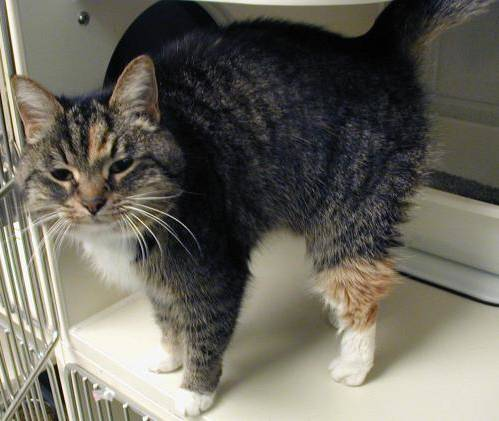

In [ ]:
img_cat = load_img(img_path_cat)
img_cat

In [ ]:
img_dog_path = '/content/temp/cats_and_dogs_filtered/train/dogs/dog.322.jpg'
img_dog = cv2.imread(img_dog_path)
img_dog.shape

(398, 499, 3)

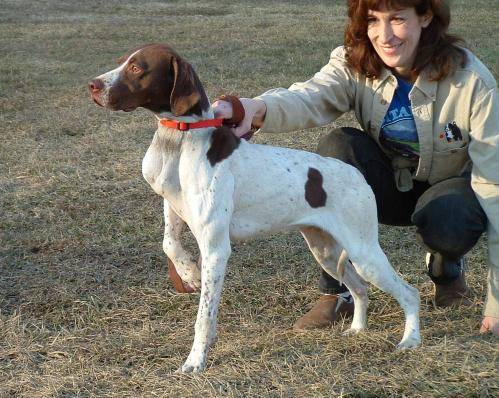

In [ ]:
img_dog = load_img(img_dog_path)
img_dog

# Step-2 Data Augmentation


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 30,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.3,
                                   zoom_range = 0.3,
                                   shear_range = 0.2,
                                   fill_mode = 'nearest',
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 30,
                                                    class_mode = 'binary',
                                                    classes = classes,
                                                    target_size = (256,256))

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                             batch_size = 30,
                                                             class_mode = 'binary',
                                                             classes = classes,
                                                             target_size = (256,256))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_generator.class_indices
validation_generator.class_indices

{'dogs': 0, 'cats': 1}

# Step-3  Loading the base model(Pretrained_model)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

conv_base = VGG16(input_shape = (256,256,3),
                  include_top =False,
                  weights = 'imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Freeze the layers
for layer in conv_base.layers:
  layer.trainable = False

# Step-3 Compile and Fit

In [ ]:
# Flattening output layer
x = Flatten()(conv_base.output)

# Adding fully connected Layer with 512 hidden units and relu as activation function
x = Dense(512, activation = 'relu')(x)

#Add Dropout
x = layers.Dropout(0.3)(x)

# Adding output layer with 1 neuron
x = layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.models.Model(conv_base.input, x)

model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics = ['accuracy', 'Precision', 'Recall'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
vgg_history_obj = model.fit(train_generator,
                            validation_data = validation_generator,
                            epochs = 10,
                            use_multiprocessing = True,
                            workers = 20)

Epoch 1/10
67/67 [==============================] - 80s 1s/step - loss: 1.9352 - accuracy: 0.6900 - precision: 0.6866 - recall: 0.6990 - val_loss: 0.3227 - val_accuracy: 0.8790 - val_precision: 0.8217 - val_recall: 0.9680
Epoch 2/10
67/67 [==============================] - 94s 1s/step - loss: 0.4253 - accuracy: 0.8125 - precision: 0.8097 - recall: 0.8170 - val_loss: 0.2538 - val_accuracy: 0.8900 - val_precision: 0.9392 - val_recall: 0.8340
Epoch 3/10
67/67 [==============================] - 86s 1s/step - loss: 0.4079 - accuracy: 0.8125 - precision: 0.8002 - recall: 0.8330 - val_loss: 0.3625 - val_accuracy: 0.8030 - val_precision: 0.9840 - val_recall: 0.6160
Epoch 4/10
67/67 [==============================] - 91s 1s/step - loss: 0.3935 - accuracy: 0.8145 - precision: 0.8161 - recall: 0.8120 - val_loss: 0.2949 - val_accuracy: 0.8540 - val_precision: 0.9538 - val_recall: 0.7440
Epoch 5/10
67/67 [==============================] - 74s 1s/step - loss: 0.3713 - accuracy: 0.8370 - precision: 0

In [ ]:
print(vgg_history_obj.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


# Step-5 Model Evaluation

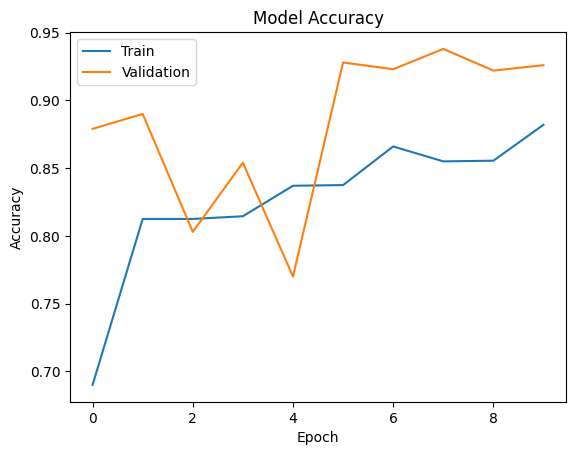

In [ ]:
plt.plot(vgg_history_obj.history['accuracy'])
plt.plot(vgg_history_obj.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

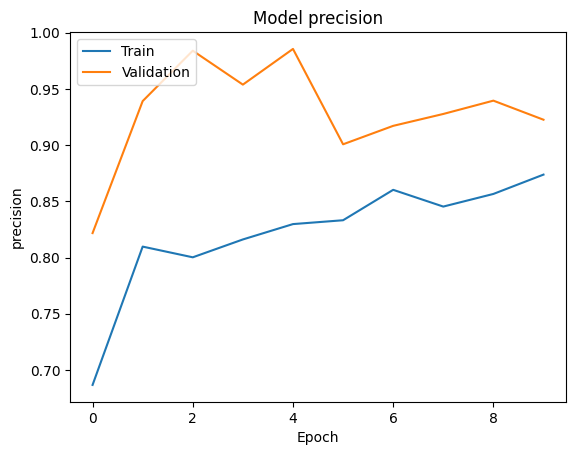

In [ ]:
plt.plot(vgg_history_obj.history['precision'])
plt.plot(vgg_history_obj.history['val_precision'])
plt.title('Model precision')
plt.ylabel('precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

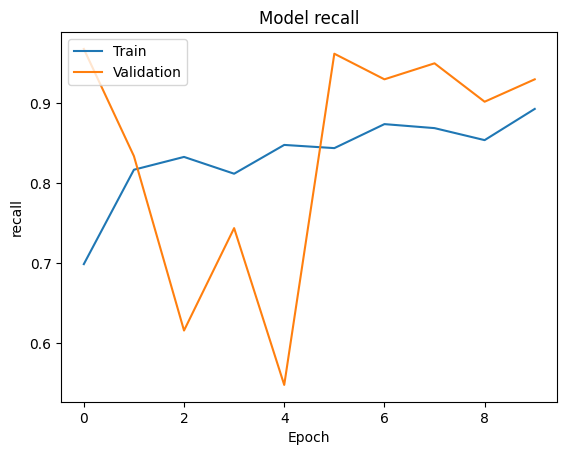

In [ ]:
plt.plot(vgg_history_obj.history['recall'])
plt.plot(vgg_history_obj.history['val_recall'])
plt.title('Model recall')
plt.ylabel('recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [ ]:
# Saving the model
model_weights_dir = 'Weights'
os.makedirs(model_weights_dir, exist_ok = True)

# Saving the model
model.save(os.path.join(model_weights_dir, 'Best_model.tf'), save_format= 'tf')

In [ ]:
load_model = tf.keras.models.load_model('/content/Weights/Best_model.tf')

In [ ]:
load_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
image_test_path = '/content/temp/cats_and_dogs_filtered/train/dogs/dog.322.jpg'
image_test_path_matrix = cv2.imread(image_test_path)
image_test_path_matrix.shape

(398, 499, 3)

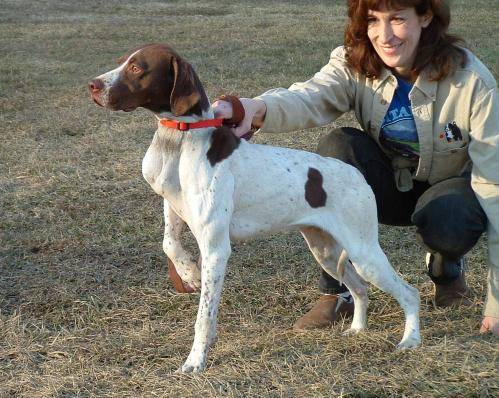

In [ ]:
image_test = load_img(image_test_path)
image_test

In [ ]:
image_test_matrix = img_to_array(image_test)
image_test_resize_matrix = cv2.resize(image_test_matrix, (256,256))
#image_test_resize_matrix.shape
image_test_resize_matrix_normal = image_test_resize_matrix/300
#image_test_resize_matrix_normal
image_test_resize_matrix_normal_flatten = image_test_resize_matrix_normal.reshape(1,256,256,3)
label = load_model.predict(image_test_resize_matrix_normal_flatten)

1/1 [==============================] - 0s 29ms/step


In [ ]:
print(label)
if label[0][0] <= 0.5:
  print('Predicted class is Dog')
else:
  print('Predicted class is Cats')

[[0.0001824]]
Predicted class is Dog
